In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipeline import preprocessing_pipeline
from myproject.pipelines.clean_pipeline import cleaning_pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_classification_ml")

/home/jakub/.venvs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Experiment: artifact_location='mlflow-artifacts:/454137213308002966', creation_time=1764624674955, experiment_id='454137213308002966', last_update_time=1764624674955, lifecycle_stage='active', name='credit_classification_ml', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [36]:
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")

le = LabelEncoder()
df["Credit_Score_encoded"] = le.fit_transform(df["Credit_Score"])
class_mapping = dict(enumerate(le.classes_))
print("class mapping:", class_mapping)


class mapping: {0: 'Good', 1: 'Poor', 2: 'Standard'}


/tmp/ipykernel_58792/2452429756.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")


In [ ]:
X = df.drop(columns=["Credit_Score"])
y = df["Credit_Score_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clean = cleaning_pipeline()
prep = preprocessing_pipeline()

SyntaxError: '(' was never closed (1283956947.py, line 1)

In [3]:


xgb_clf = Pipeline([
    ("clean",clean),
    ("prep",prep),
    ("xgb_clf", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=4
    ) )
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
}

cv_result_base = cross_validate(
    xgb_clf,
    X_train, 
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=1,
    verbose=1,
)

cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_base_metrics = {**cv_base_metrics_mean, **cv_base_metrics_std }
pd.DataFrame([cv_base_metrics])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.753088,0.735358,0.73586,0.736575,0.735358,0.001384,0.00175,0.001794,0.002166,0.00175


In [4]:
xgb_clf.fit(X_train, y_train)

y_pred_base = xgb_clf.predict(X_test)

test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.75525,0.737354,0.738119,0.739152,0.737354


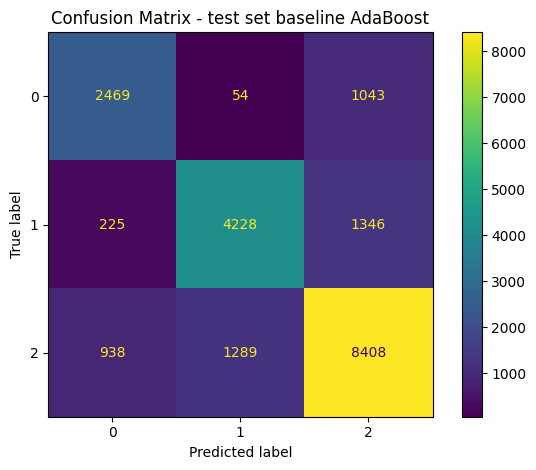

In [5]:
cm = confusion_matrix(y_test, y_pred_base)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - test set baseline AdaBoost")
plt.tight_layout()
plt.show()

In [ ]:
# with mlflow.start_run(run_name="XGBoost_Baseline"):
#     mlflow.log_metrics(cv_base_metrics)
#     mlflow.log_metrics(test_metrics_base)

🏃 View run XGBoost_Baseline at: http://127.0.0.1:5000/#/experiments/454137213308002966/runs/061b1988cb164729b8bd18e2f58e7d81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/454137213308002966


In [10]:
cv_optuna = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 15.0),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        
         "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
         
         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
         
         "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
         "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
    }
    
    xgb_optuna =XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=4,
        random_state=42,
        **params)
    
    pipe = Pipeline([
        ("clean",clean),
        ("prep",prep),
        ("xgb_optuna", xgb_optuna)
    ])
    
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="f1_macro",
        cv=cv_optuna,
        n_jobs=1
    )
    
    return scores.mean()


In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

[I 2025-12-03 16:18:49,131] A new study created in memory with name: no-name-3eb88cf7-f268-4f01-953d-a799c554ea24
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 in

In [33]:
study.best_value

0.7643388258933813

In [32]:
study.best_trial

FrozenTrial(number=31, state=<TrialState.COMPLETE: 1>, values=[0.7643388258933813], datetime_start=datetime.datetime(2025, 12, 3, 16, 29, 17, 450728), datetime_complete=datetime.datetime(2025, 12, 3, 16, 30, 5, 193809), params={'max_depth': 10, 'min_child_weight': 12.606226538525585, 'gamma': 0.0067741567920485135, 'n_estimators': 1149, 'learning_rate': 0.08668003636034612, 'subsample': 0.6893495337578907, 'colsample_bytree': 0.9873505170636493, 'reg_alpha': 0.002488658605215616, 'reg_lambda': 0.010800116379132122}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': FloatDistribution(high=15.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'n_estimators': IntDistribution(high=1200, log=False, low=300, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, l

In [38]:
best_params = study.best_params

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

xgb_best = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=4,
    random_state=42,
    **best_params,
)

# Użyj callbacku EarlyStopping, bo w nowym XGBoost nie ma już parametru early_stopping_rounds w fit
early_stop = [
    callback.EarlyStopping(
        rounds=50,
        save_best=True,
        data_name="validation_0",
        metric_name="mlogloss",
    )
]

pipe_best = Pipeline([
    ("clean", clean),
    ("prep", prep),
    ("xgb_clf", xgb_best),
])

pipe_best.fit(
    X_tr,
    y_tr,
    xgb_clf__eval_set=[(X_val, y_val)],
    xgb_clf__callbacks=early_stop,
    xgb_clf__verbose=50,
)
print("Best iteration:", pipe_best.named_steps["xgb_clf"].best_iteration)


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
best_n = pipe_best.named_steps["xgb_clf"].best_iteration
print("Best ITERATION: ", best_n)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ID: object, Customer_ID: object, Month: object, Name: object, Age: object, SSN: object, Occupation: object, Annual_Income: object, Num_of_Loan: object, Type_of_Loan: object, Num_of_Delayed_Payment: object, Changed_Credit_Limit: object, Credit_Mix: object, Outstanding_Debt: object, Credit_History_Age: object, Payment_of_Min_Amount: object, Amount_invested_monthly: object, Payment_Behaviour: object, Monthly_Balance: object